<a href="https://colab.research.google.com/github/asarria48/Nuclear-physics/blob/main/Informe1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gráfica simultánea de los tres espectros

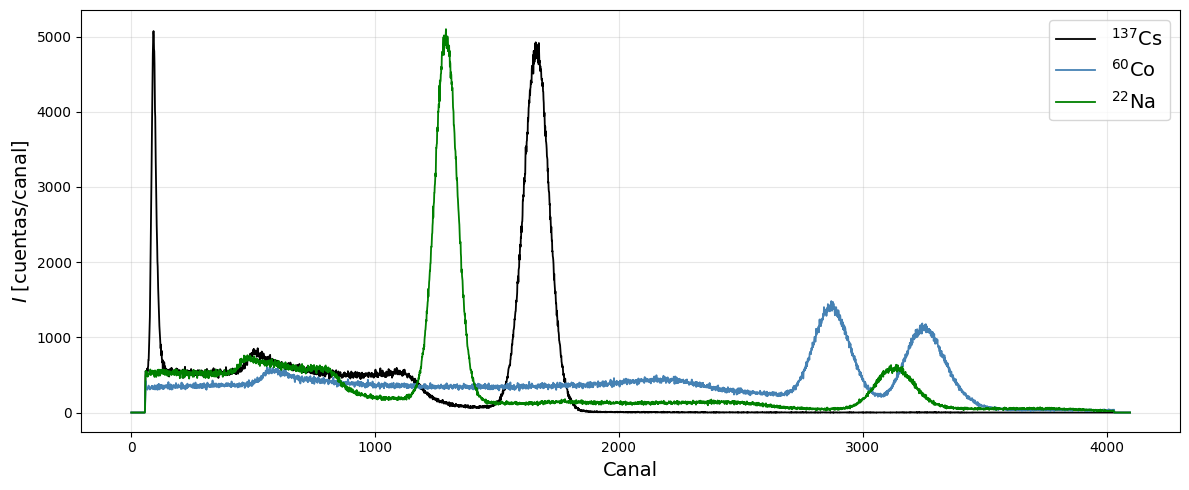

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Nombres de los archivos .csv que quiero comparar
archivos = [
    "Cs137_5minNaI.csv",
    "Co60_10minNaI.csv",
    "Na22_10minNaI.csv"
]

colores = ['black', 'steelblue', 'green']
etiquetas = ['$^{137}$Cs', '$^{60}$Co', '$^{22}$Na']

plt.figure(figsize=(12, 5))


for archivo, color, etiqueta in zip(archivos, colores, etiquetas):
    data = pd.read_csv(archivo)
    x = data.iloc[:, 0].values   # primera columna: canal
    y = data.iloc[:, 1].values   # segunda columna: cuentas
    plt.plot(x, y, lw=1.3, color=color, label=etiqueta)

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


# Cobalto 60
lims: 2400 - 3700 (están juntas)

<>:145: SyntaxWarning: invalid escape sequence '\D'
<>:145: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-646194444.py:145: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Cuentas/$\Delta t$")


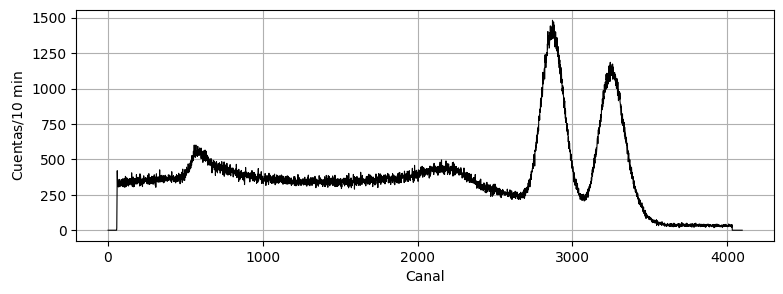


Resultados del ajuste (dos gaussianas + fondo lineal):

μ1 = 2873.2(2) canales
σ1 = 71.4(2) canales
FWHM1 = 168.1(5) canales
I1 = 216552(668) canal·cuentas

μ2 = 3256.8(2) canales
σ2 = 79.5(3) canales
FWHM2 = 187.1(7) canales
I2 = 199810(745) canal·cuentas


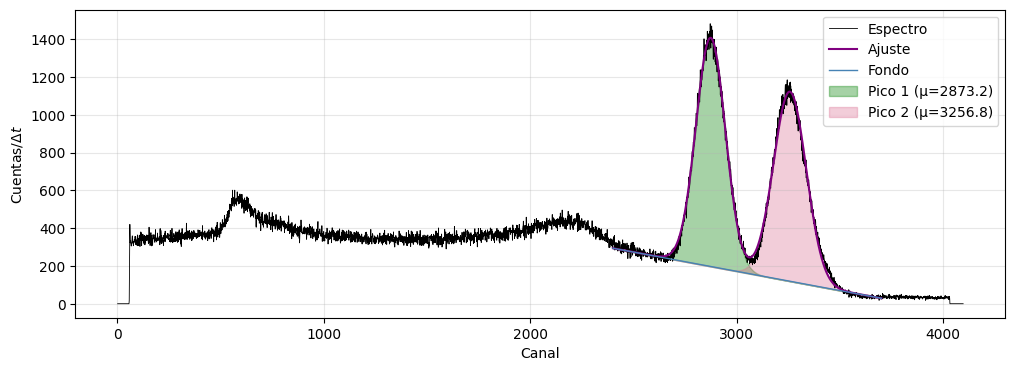

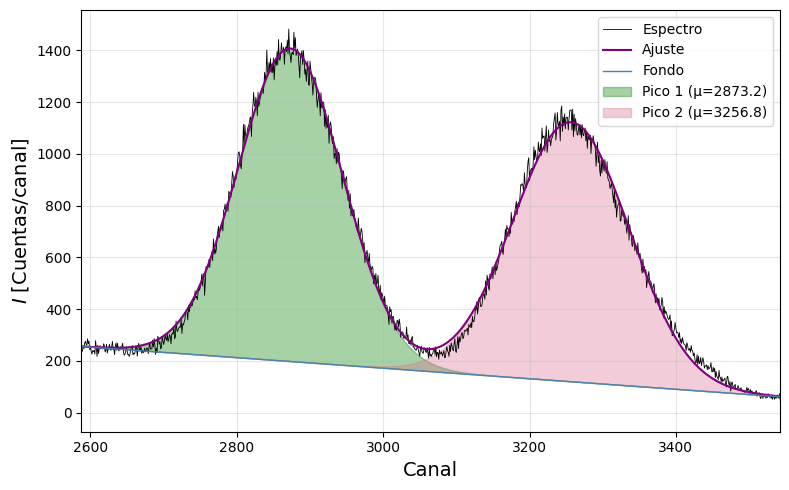


Intensidad total: 416362(1000) canal·cuentas


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks


def gaussian(x, A, mu, sigma):                                                        # una gaussiana
    return A * np.exp(-(mu - x)**2 / (2 * sigma**2))

def two_gauss_linbg(x, A1, mu1, sigma1, A2, mu2, sigma2, m, b):                       # dos gaussianas + fondo
    return (gaussian(x, A1, mu1, sigma1) + gaussian(x, A2, mu2, sigma2) + m*x + b)


archivo = "Co60_10minNaI.csv"                                                         # cambio entre .csv
data = pd.read_csv(archivo)                                                           # columna 0: canal, columna 1: cuentas

x = data.iloc[:,0].values
y = data.iloc[:,1].values


# para ver el espectro completo
plt.figure(figsize=(9,3))
plt.plot(x, y, lw=0.8, color='black')
plt.xlabel("Canal")
plt.ylabel("Cuentas/$10$ min")                                                         # acomodar el \Delta t de acuerdo al núcleo
#plt.title("Espectro completo")
plt.grid(True)
plt.show()


# selecciono la region que contiene dos picos
x_min = 2400                                                                          # rango seleccionado a "ojo" después de ver el espectro. No acercarse demasiado al sitio donde empiezan a subir las cuentas para no dañar el ajuste
x_max = 3700
mask = (x >= x_min) & (x <= x_max)
x_region = x[mask]
y_region = y[mask]


# para detectar los máximos locales
peaks, _ = find_peaks(y_region, height=np.max(y_region)*0.2, distance=50)
if len(peaks) >= 2:                                                                   # si hay al menos dos máximos locales
    peaks_sorted = peaks[np.argsort(y_region[peaks])][::-1][:2]                       # tomo los más altos
    mu1_guess = x_region[peaks_sorted[0]]                                             # estimo las mu
    mu2_guess = x_region[peaks_sorted[1]]
else:
    idx_sorted = np.argsort(y_region)[::-1]                                           # si no hay locales, estimo los globales
    mu1_guess = x_region[idx_sorted[0]]
    mu2_guess = x_region[idx_sorted[1]]


# para comenzar el ajuste, tengo los valores estimados (que luego se van a corregir)
A1_guess = y_region.max()                                                             # amplitud máxima observada
A2_guess = y_region.max() * 0.8                                                       # amplitud máxima pero modulada para ser un poco menor
sigma1_guess = 50.0                                                                   # anchos estimados a ojo, el ajuste los va a corregir
sigma2_guess = 60.0
m_guess = 0.0                                                                         # el espectro está más o menos plano en el fondo, igual el ajuste corregirá esto
b_guess = np.median(y_region)                                                         # el fondo está alrededor de la media de los valores sin pico

p0 = [A1_guess, mu1_guess, sigma1_guess,
      A2_guess, mu2_guess, sigma2_guess,
      m_guess, b_guess]


minA, maxA = 0, np.max(y)*2                                                                       # limites de las variables, el máximo es el doble observado en los datos para evitar errores
minSigma, maxSigma = 1e-1, 500                                                                    # evito que sigma sea cero o muy grande
bounds_lower = [0, x_region.min(), minSigma, 0, x_region.min(), minSigma, -np.inf, -np.inf]       # límites inferiores para todos los parámetros
bounds_upper = [maxA, x_region.max(), maxSigma, maxA, x_region.max(), maxSigma, np.inf, np.inf]   # límites superiores para todos los parámetros


popt, pcov = curve_fit(two_gauss_linbg, x_region, y_region, p0=p0, bounds=(bounds_lower, bounds_upper), maxfev=10000)       # hacer el ajuste con curve_fit

(A1, mu1, sigma1, A2, mu2, sigma2,m, b) = popt                                  # los parámetros ajustados

perr = np.sqrt(np.diag(pcov))                                                   # errores de los parámetros ajustados


c = np.sqrt(2*np.pi)                                                            # para calcular la intensidad

I1 = A1 * sigma1 * c                                                            # intensidad del primer pico
I2 = A2 * sigma2 * c                                                            # intensidad del segundo pico


# pcov es la matriz de covarianzas de los parámetros ajustados incluídos en popt
# var(I) = (dI/dA)^2 VarA + (dI/dsigma)^2 Varsigma + 2 (dI/dA)(dI/dsigma) Cov(A,sigma) es la propagación de incertidumbres para la intensidad

varA1 = pcov[0,0]                                                               # varianza de A1 (posición 0)
varsig1 = pcov[2,2]                                                             # varianza de sigma1 (posición 2)
covA1sig1 = pcov[0,2]                                                           # covarianza entre A1 y sigma1 (posición 0,2 --> elemento cruzado)

varA2 = pcov[3,3]                                                               # varianza de A2
varsig2 = pcov[5,5]                                                             # varianza de sigma2
covA2sig2 = pcov[3,5]                                                           # covarianza entre A2 y sigma2

# propagación de incertidumbres para ambas intensidades
varI1 = (sigma1*c)**2 * varA1 + (A1*c)**2 * varsig1 + 2*(sigma1*c)*(A1*c)*covA1sig1
varI2 = (sigma2*c)**2 * varA2 + (A2*c)**2 * varsig2 + 2*(sigma2*c)*(A2*c)*covA2sig2

# incertidumbre estándar
dI1 = np.sqrt(varI1) if varI1>0 else np.nan
dI2 = np.sqrt(varI2) if varI2>0 else np.nan

FWHM1 = 2.355 * sigma1                                                          # ancho total a la mitad de la altura para el primer pico
FWHM2 = 2.355 * sigma2                                                          # ancho total a la mitad de la altura para el segundo pico
dFWHM1 = 2.355 * perr[2]                                                        # propagación del error del FWHM1 a partir de sigma 1
dFWHM2 = 2.355 * perr[5]                                                        # propagación del error del FWHM2 a partir de sigma 2


def fmt_par(x, dx):
    if np.isnan(dx):
        return f"{x:.4g}"
    dec = int(np.floor(np.log10(abs(dx)))) if dx != 0 else 0
    ndec = max(0, -dec)
    x_str = f"{x:.{ndec}f}"
    dx_str = str(int(round(dx * 10**ndec)))
    return f"{x_str}({dx_str})"

# --- RESULTADOS ---
print("\nResultados del ajuste (dos gaussianas + fondo lineal):\n")
print(f"μ1 = {fmt_par(mu1, perr[1])} canales")
print(f"σ1 = {fmt_par(sigma1, perr[2])} canales")
print(f"FWHM1 = {fmt_par(FWHM1, dFWHM1)} canales")
print(f"I1 = {fmt_par(I1, dI1)} canal·cuentas")
print(f"\nμ2 = {fmt_par(mu2, perr[4])} canales")
print(f"σ2 = {fmt_par(sigma2, perr[5])} canales")
print(f"FWHM2 = {fmt_par(FWHM2, dFWHM2)} canales")
print(f"I2 = {fmt_par(I2, dI2)} canal·cuentas")

xfine = np.linspace(x_region.min(), x_region.max(), 2000)
total_fit = two_gauss_linbg(xfine, *popt)
g1 = gaussian(xfine, A1, mu1, sigma1)
g2 = gaussian(xfine, A2, mu2, sigma2)
bg = m*xfine + b

plt.figure(figsize=(12,4))
plt.plot(x, y, color='black', lw=0.6, label="Espectro")
plt.plot(xfine, total_fit, color='purple', lw=1.5, label="Ajuste")
plt.plot(xfine, bg, color='steelblue', lw=1, label="Fondo")

# relleno gaussianas para que se vea bien el ajuste
plt.fill_between(xfine, bg, g1 + bg, where=(g1 + bg > bg), color='green', alpha=0.35, label=f"Pico 1 (μ={mu1:.1f})")
plt.fill_between(xfine, bg, g2 + bg, where=(g2 + bg > bg), color='palevioletred', alpha=0.35, label=f"Pico 2 (μ={mu2:.1f})")

plt.xlabel("Canal")
plt.ylabel("Cuentas/$\Delta t$")
#plt.title("Ajuste: dos gaussianas + fondo lineal")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# para ver de cerca los picos
plt.figure(figsize=(8,5))
plt.plot(x, y, color='black', lw=0.6, label="Espectro")
plt.plot(xfine, total_fit, color='purple', lw=1.5, label="Ajuste")
plt.plot(xfine, bg, color='steelblue', lw=1, label="Fondo")

# relleno gaussianas para que se vea bien el ajuste
plt.fill_between(xfine, bg, g1 + bg, where=(g1 + bg > bg), color='green', alpha=0.35, label=f"Pico 1 (μ={mu1:.1f})")
plt.fill_between(xfine, bg, g2 + bg, where=(g2 + bg > bg), color='palevioletred', alpha=0.35, label=f"Pico 2 (μ={mu2:.1f})")

plt.xlim(mu1 - 4*sigma1, mu2 + 4*sigma1)   # zoom alrededor de los picos
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

I_total = I1 + I2
dI_total = np.sqrt(dI1**2 + dI2**2)

print(f"\nIntensidad total: {fmt_par(I_total, dI_total)} canal·cuentas")



#Cesio 137
lims1: 60 - 450,
lims2: 1200 - 2000

<>:20: SyntaxWarning: invalid escape sequence '\D'
<>:20: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1015418178.py:20: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Cuentas/$\Delta t$")                                                         # acomodar el \Delta t de acuerdo al núcleo


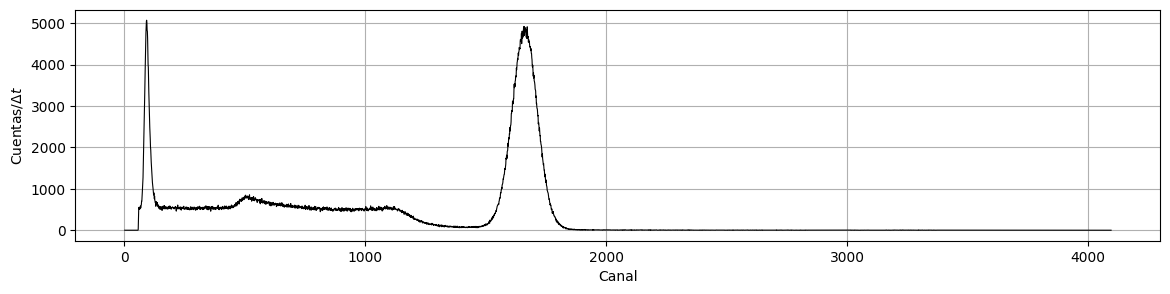


--- Resultados del primer pico ---
 μ1 = 94 ± 0.0998 canales
 σ1 = 9.68 ± 0.0927 canales
 FWHM1 = 22.8 ± 0.218 canales
 A1 = 4.22e+03 ± 48.4 cuentas
 a0 = 560 ± 10.1, a1 = -0.0599 ± 0.0337
 Intensidad = 1.02e+05 ± 1.03e+03 cuentas·canal

--- Resultados del segundo pico ---
 μ2 = 1.66e+03 ± 0.0682 canales
 σ2 = 52.2 ± 0.0737 canales
 FWHM2 = 123 ± 0.174 canales
 A2 = 4.75e+03 ± 5.48 cuentas
 a0 = 409 ± 10.5, a1 = -0.211 ± 0.00658
 Intensidad = 6.21e+05 ± 876 cuentas·canal


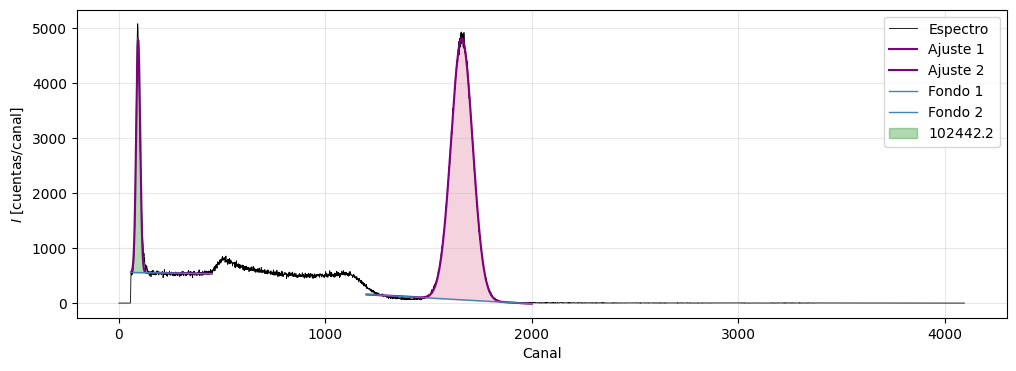

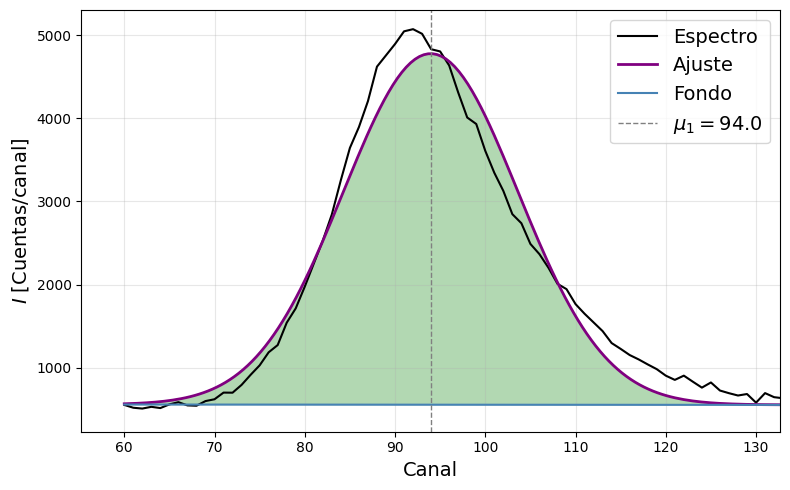

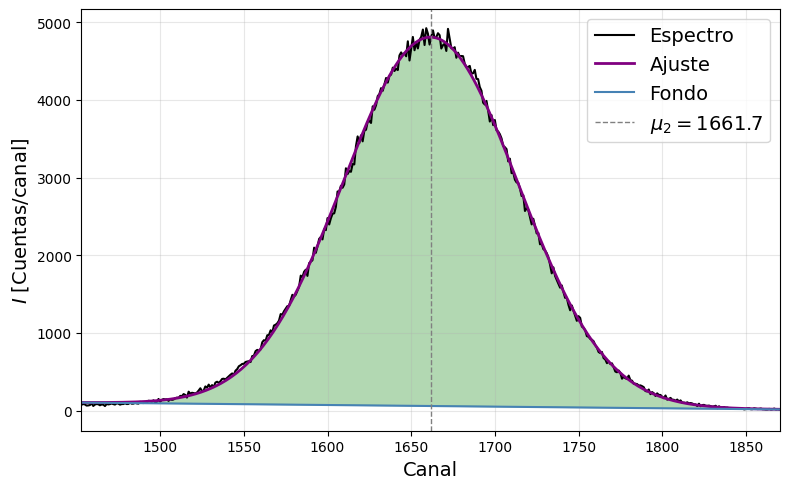

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def gauss_bg(x, mu, sigma, A, a0, a1):                                               # una gaussiana con fondo lineal mx + b
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x


archivo = "Cs137_5minNaI.csv"                    # archivo con los datos
data = pd.read_csv(archivo)
x = data.iloc[:, 0].values                       # canal
y = data.iloc[:, 1].values                       # cuentas

# para ver el espectro completo
plt.figure(figsize=(14,3))
plt.plot(x, y, lw=0.8, color='black')
plt.xlabel("Canal")
plt.ylabel("Cuentas/$\Delta t$")                                                         # acomodar el \Delta t de acuerdo al núcleo
plt.grid(True)
plt.show()


# defino la región del primer pico
x_min1, x_max1 = 60, 450                                                              # límites a ojo para empezar
mask1 = (x >= x_min1) & (x <= x_max1)
x_region1 = x[mask1]
y_region1 = y[mask1]

                                                                                      # estimaciones iniciales que voy a ajustar:
mu1_guess = x_region1[np.argmax(y_region1)]                                           # centro inicial en el máximo local
A1_guess = y_region1.max()                                                            # altura inicial
sigma1_guess = 30.0                                                                   # ancho inicial (10% del rango)
a0_guess = np.median(y_region1)                                                       # valor medio como base inicial
a1_guess = 0.0                                                                        # pendiente inicial nula

p0_1 = [mu1_guess, sigma1_guess, A1_guess, a0_guess, a1_guess]

# Ajuste no lineal con todos los parámetros libres
y_err = np.sqrt(y_region1)   # incertidumbre Poisson para cada canal
popt1, pcov1 = curve_fit(gauss_bg, x_region1, y_region1, p0=p0_1, sigma=y_err)
mu1, sigma1, A1, a0_1, a1_1 = popt1
perr1 = np.sqrt(np.diag(pcov1))


# defino la región del segundo pico (todo igual pero con estimaciones a ojo para el pico más a la derecha)
x_min2, x_max2 = 1200, 2000
mask2 = (x >= x_min2) & (x <= x_max2)
x_region2 = x[mask2]
y_region2 = y[mask2]

mu2_guess = x_region2[np.argmax(y_region2)]
A2_guess = y_region2.max()
sigma2_guess = 50.0
a0_guess = np.median(y_region2)
a1_guess = 0.0

p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess, a1_guess]

popt2, pcov2 = curve_fit(gauss_bg, x_region2, y_region2, p0=p0_2)
mu2, sigma2, A2, a0_2, a1_2 = popt2
perr2 = np.sqrt(np.diag(pcov2))


c = np.sqrt(2 * np.pi)

def intensidad(A, sigma, pcov):
    varA = pcov[2, 2]
    varsig = pcov[1, 1]
    covA_sig = pcov[2, 1]
    I = A * sigma * c
    varI = (sigma * c) ** 2 * varA + (A * c) ** 2 * varsig + 2 * (sigma * c) * (A * c) * covA_sig
    dI = np.sqrt(varI)
    return I, dI

I1, dI1 = intensidad(A1, sigma1, pcov1)
I2, dI2 = intensidad(A2, sigma2, pcov2)

FWHM1 = 2.355 * sigma1
FWHM2 = 2.355 * sigma2
dFWHM1 = 2.355 * perr1[1]
dFWHM2 = 2.355 * perr2[1]



def fmt(x, dx=None):
    if dx is None or np.isnan(dx):
        return f"{x:.3g}"
    else:
        return f"{x:.3g} ± {dx:.3g}"

print("\n--- Resultados del primer pico ---")
print(f" μ1 = {fmt(mu1, perr1[0])} canales")
print(f" σ1 = {fmt(sigma1, perr1[1])} canales")
print(f" FWHM1 = {fmt(FWHM1, dFWHM1)} canales")
print(f" A1 = {fmt(A1, perr1[2])} cuentas")
print(f" a0 = {fmt(a0_1, perr1[3])}, a1 = {fmt(a1_1, perr1[4])}")
print(f" Intensidad = {fmt(I1, dI1)} cuentas·canal")

print("\n--- Resultados del segundo pico ---")
print(f" μ2 = {fmt(mu2, perr2[0])} canales")
print(f" σ2 = {fmt(sigma2, perr2[1])} canales")
print(f" FWHM2 = {fmt(FWHM2, dFWHM2)} canales")
print(f" A2 = {fmt(A2, perr2[2])} cuentas")
print(f" a0 = {fmt(a0_2, perr2[3])}, a1 = {fmt(a1_2, perr2[4])}")
print(f" Intensidad = {fmt(I2, dI2)} cuentas·canal")


xf1 = np.linspace(x_region1.min(), x_region1.max(), 800)
xf2 = np.linspace(x_region2.min(), x_region2.max(), 800)
fit1 = gauss_bg(xf1, *popt1)
fit2 = gauss_bg(xf2, *popt2)
bg1 = a0_1 + a1_1 * xf1
bg2 = a0_2 + a1_2 * xf2

plt.figure(figsize=(12, 4))
plt.plot(x, y, color='black', lw=0.6, label='Espectro')
plt.plot(xf1, fit1, color='purple', lw=1.5, label="Ajuste 1")
plt.plot(xf2, fit2, color='purple', lw=1.5, label="Ajuste 2")
plt.plot(xf1, bg1, color='steelblue', lw=1, label='Fondo 1')
plt.plot(xf2, bg2,color='steelblue', lw=1, label='Fondo 2')
plt.fill_between(xf1, bg1, fit1, where=(fit1 > bg1), color='green', alpha=0.3, label=fr'${I1:.1f}$')
plt.fill_between(xf2, bg2, fit2, where=(fit2 > bg2), color='palevioletred', alpha=0.3)
plt.xlabel("Canal")
plt.ylabel("$I$ [cuentas/canal]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# para ver de cerca el primer pico
plt.figure(figsize=(8,5))
plt.plot(x_region1, y_region1, color='black', markersize=3, label='Espectro')
plt.plot(xf1, fit1, color='purple', lw=2, label='Ajuste')
plt.plot(xf1, bg1, color='steelblue', lw=1.5, label='Fondo')
plt.fill_between(xf1, bg1, fit1, where=(fit1>bg1), color='green', alpha=0.3)

# Indico el centro del pico ajustado
plt.axvline(mu1, color='gray', ls='--', lw=1, label=fr'$\mu_1 = {mu1:.1f}$')

plt.xlim(mu1 - 4*sigma1, mu1 + 4*sigma1)   # zoom alrededor del pico (~4 sigmas)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# para ver de cerca el segundo pico
plt.figure(figsize=(8,5))
plt.plot(x_region2, y_region2, color='black', markersize=3, label='Espectro')
plt.plot(xf2, fit2, color='purple', lw=2, label='Ajuste')
plt.plot(xf2, bg2, color='steelblue', lw=1.5, label='Fondo')
plt.fill_between(xf2, bg2, fit2, where=(fit2>bg2), color='green', alpha=0.3)

# Indico el centro del pico ajustado
plt.axvline(mu2, color='gray', ls='--', lw=1, label=fr'$\mu_2 = {mu2:.1f}$')

plt.xlim(mu2 - 4*sigma2, mu2 + 4*sigma2)   # zoom alrededor del pico (~4 sigmas)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



Se nota que el ajuste para el primer pico no funciona con una sola gaussiana, a continuación probamos el ajuste con dos

<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-3711320603.py:24: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Cuentas/$\Delta t$")                                                         # acomodar el \Delta t de acuerdo al núcleo


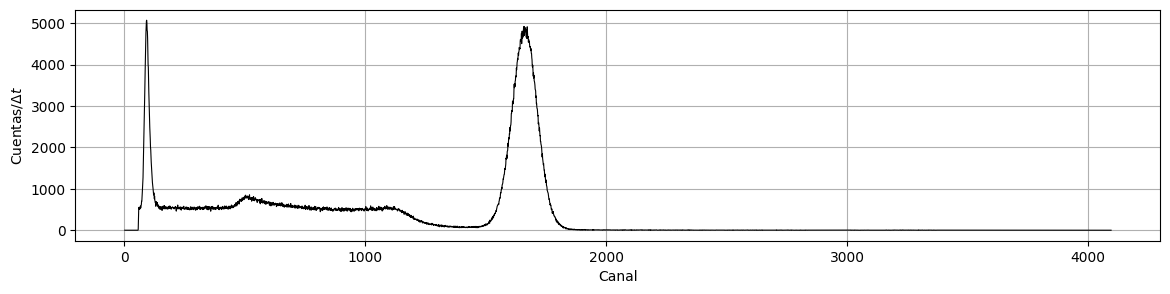

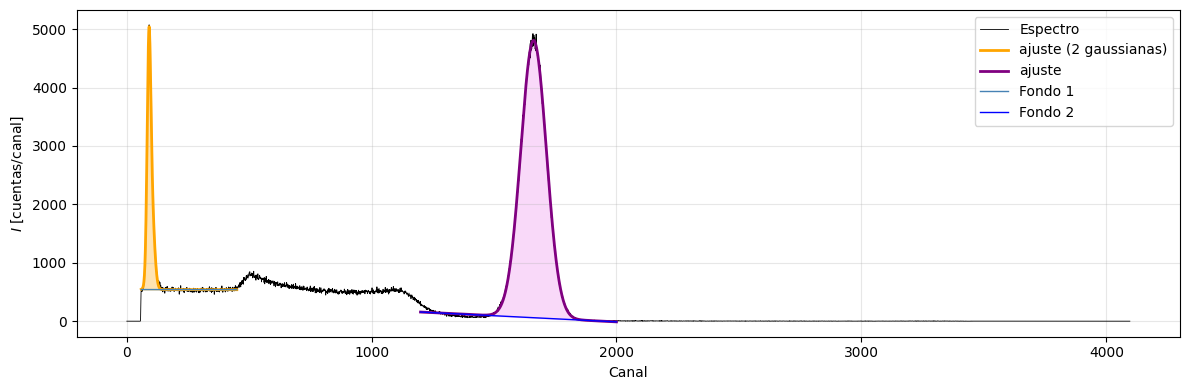

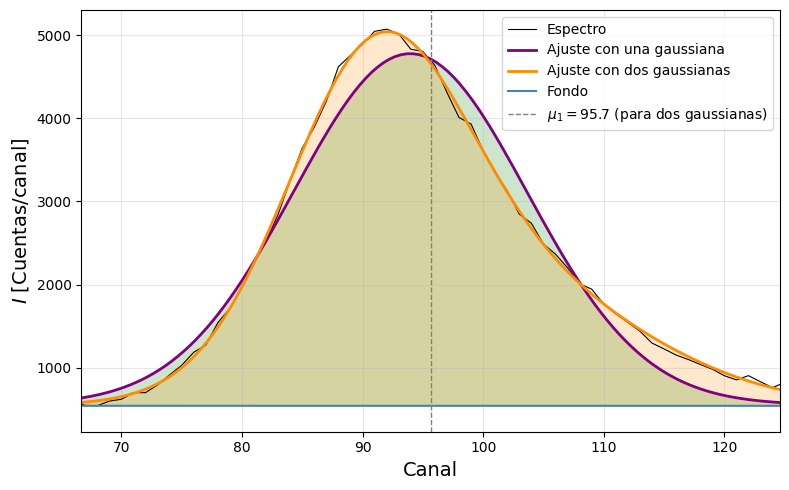


=== PARÁMETROS DEL PRIMER FOTOPICO ===

       Parámetro          Resultado
             µ₁a        90.89(0.06)
             σ₁a         7.24(0.10)
          FWHM₁a        17.05(0.24)
             µ₁b       100.41(0.65)
             σ₁b        11.88(0.21)
          FWHM₁b        27.98(0.49)
Intensidad total 106794.62(3388.78)

=== PARÁMETROS DEL SEGUNDO FOTOPICO ===

 Parámetro          Resultado
        µ₂      1661.67(0.07)
        σ₂        52.19(0.07)
     FWHM₂       122.89(0.17)
Intensidad 621062.49(1133.35)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gauss_bg(x, mu, sigma, A, a0, a1):                                                # una gaussiana con fondo lineal mx + b
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

def double_gauss_bg(x, mu1, sigma1, A1, mu2, sigma2, A2, a0, a1):                     # dos gaussianas con fondo lineal
    return (A1 * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2) +
            A2 * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2) +
            a0 + a1 * x)


archivo = "Cs137_5minNaI.csv"                    # archivo con los datos
data = pd.read_csv(archivo)
x = data.iloc[:, 0].values                       # canal
y = data.iloc[:, 1].values                       # cuentas

# para ver el espectro completo
plt.figure(figsize=(14,3))
plt.plot(x, y, lw=0.8, color='black')
plt.xlabel("Canal")
plt.ylabel("Cuentas/$\Delta t$")                                                         # acomodar el \Delta t de acuerdo al núcleo
plt.grid(True)
plt.show()


# defino la región del primer pico
x_min1, x_max1 = 60, 450                                                                  # límites a ojo para empezar
mask1 = (x >= x_min1) & (x <= x_max1)
x_region1 = x[mask1]
y_region1 = y[mask1]

# estimaciones iniciales que voy a ajustar:
mu1_guess = x_region1[np.argmax(y_region1)]                                           # centro inicial en el máximo local
A1_guess = y_region1.max()                                                            # altura inicial
sigma1_guess = 30.0                                                                   # ancho inicial (10% del rango)
a0_guess = np.median(y_region1)                                                       # valor medio como base inicial
a1_guess = 0.0                                                                        # pendiente inicial nula

p0_1 = [mu1_guess, sigma1_guess, A1_guess, a0_guess, a1_guess]

# Ajuste no lineal con todos los parámetros libres (una sola gaussiana)
y_err = np.sqrt(y_region1)   # incertidumbre Poisson para cada canal
popt1, pcov1 = curve_fit(gauss_bg, x_region1, y_region1, p0=p0_1, sigma=y_err)

# Ajuste de dos gaussianas para el primer pico
# estimaciones iniciales
mu1a_guess = mu1_guess - 20
mu1b_guess = mu1_guess + 20
sigma1a_guess = 25.0
sigma1b_guess = 25.0
A1a_guess = A1_guess * 0.6
A1b_guess = A1_guess * 0.4

p0_1double = [mu1a_guess, sigma1a_guess, A1a_guess,
              mu1b_guess, sigma1b_guess, A1b_guess,
              a0_guess, a1_guess]

popt1_double, pcov1_double = curve_fit(double_gauss_bg, x_region1, y_region1, p0=p0_1double)

# segundo pico
x_min2, x_max2 = 1200, 2000
mask2 = (x >= x_min2) & (x <= x_max2)
x_region2 = x[mask2]
y_region2 = y[mask2]

mu2_guess = x_region2[np.argmax(y_region2)]
A2_guess = y_region2.max()
sigma2_guess = 50.0
a0_guess2 = np.median(y_region2)
a1_guess2 = 0.0

p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]
popt2, pcov2 = curve_fit(gauss_bg, x_region2, y_region2, p0=p0_2)

# Curvas ajustadas
xf1 = np.linspace(x_region1.min(), x_region1.max(), 800)
xf2 = np.linspace(x_region2.min(), x_region2.max(), 800)
fit1_single = gauss_bg(xf1, *popt1)
fit1_double = double_gauss_bg(xf1, *popt1_double)
fit2 = gauss_bg(xf2, *popt2)
bg1 = popt1_double[6] + popt1_double[7] * xf1                                   # fondo del ajuste doble
bg2 = popt2[3] + popt2[4] * xf2


plt.figure(figsize=(12,4))
plt.plot(x, y, color='black', lw=0.6, label='Espectro')
plt.plot(xf1, fit1_double, color='orange', lw=2, label='ajuste (2 gaussianas)')
plt.plot(xf2, fit2, color='purple', lw=2, label='ajuste')
plt.plot(xf1, bg1, color='steelblue', lw=1, label='Fondo 1')
plt.plot(xf2, bg2, color='blue', lw=1, label='Fondo 2')

# Sombras de las áreas
plt.fill_between(xf1, bg1, fit1_double, where=(fit1_double > bg1), color='orange', alpha=0.3)
plt.fill_between(xf2, bg2, fit2, where=(fit2 > bg2), color='violet', alpha=0.3)

plt.xlabel("Canal")
plt.ylabel("$I$ [cuentas/canal]")
plt.legend()
plt.grid(alpha=0.3)
#plt.title("Espectro completo con ajustes de los dos picos")
plt.tight_layout()
plt.show()

# para ver bien el primer pico
plt.figure(figsize=(8,5))
plt.plot(x_region1, y_region1, color='black', lw=0.8, label='Espectro')
plt.plot(xf1, fit1_single, color='purple', lw=2, label='Ajuste con una gaussiana')
plt.plot(xf1, fit1_double, color='darkorange', lw=2, label='Ajuste con dos gaussianas')
plt.plot(xf1, bg1, color='steelblue', lw=1.5, label='Fondo')


plt.fill_between(xf1, bg1, fit1_single, where=(fit1_single>bg1), color='green', alpha=0.2)
plt.fill_between(xf1, bg1, fit1_double, where=(fit1_double>bg1), color='darkorange', alpha=0.2)

# Indico el centro ajustado (promedio de las dos gaussianas del ajuste doble)
mu1a, mu1b = popt1_double[0], popt1_double[3]
mu1_central = (mu1a + mu1b)/2
plt.axvline(mu1_central, color='gray', ls='--', lw=1, label=fr'$\mu_1 = {mu1_central:.1f}$ (para dos gaussianas)')

plt.xlim(mu1_central - 4*popt1_double[1], mu1_central + 4*popt1_double[1])   # zoom alrededor del pico (~4 sigmas)
plt.xlabel("Canal",fontsize=14)
plt.ylabel("$I$ [Cuentas/canal]", fontsize=14)
#plt.title("Primer pico: comparación entre una y dos gaussianas")
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# === TABLA DE PARÁMETROS DEL PRIMER PICO ===
params = popt1_double
perr = np.sqrt(np.diag(pcov1_double))

mu1a, sigma1a, A1a, mu1b, sigma1b, A1b, a0, a1 = params
dmu1a, dsigma1a, dA1a, dmu1b, dsigma1b, dA1b, *_ = perr

# FWHM
FWHM1a = 2.3548 * sigma1a
FWHM1b = 2.3548 * sigma1b
dFWHM1a = 2.3548 * dsigma1a
dFWHM1b = 2.3548 * dsigma1b

# Intensidades (áreas bajo las gaussianas)
area1a = A1a * sigma1a * np.sqrt(2 * np.pi)
area1b = A1b * sigma1b * np.sqrt(2 * np.pi)
darea1a = area1a * np.sqrt((dA1a / A1a)**2 + (dsigma1a / sigma1a)**2)
darea1b = area1b * np.sqrt((dA1b / A1b)**2 + (dsigma1b / sigma1b)**2)

# === Intensidad total del primer fotopico ===
area_total = area1a + area1b
darea_total = np.sqrt(darea1a**2 + darea1b**2)  # suma en cuadratura

# === Tabla final ===
tabla = pd.DataFrame({
    "Parámetro": ["µ₁a", "σ₁a", "FWHM₁a", "µ₁b", "σ₁b", "FWHM₁b", "Intensidad total"],
    "Valor": [mu1a, sigma1a, FWHM1a, mu1b, sigma1b, FWHM1b, area_total],
    "Incertidumbre": [dmu1a, dsigma1a, dFWHM1a, dmu1b, dsigma1b, dFWHM1b, darea_total]
})

# Formato (valor ± incertidumbre)
tabla["Resultado"] = tabla.apply(lambda row: f"{row['Valor']:.2f}({row['Incertidumbre']:.2f})", axis=1)
tabla_final = tabla[["Parámetro", "Resultado"]]

print("\n=== PARÁMETROS DEL PRIMER FOTOPICO ===\n")
print(tabla_final.to_string(index=False))



# === TABLA DE PARÁMETROS DEL SEGUNDO FOTOPICO ===
params2 = popt2
perr2 = np.sqrt(np.diag(pcov2))

mu2, sigma2, A2, a0_2, a1_2 = params2
dmu2, dsigma2, dA2, da0_2, da1_2 = perr2

# FWHM
FWHM2 = 2.3548 * sigma2
dFWHM2 = 2.3548 * dsigma2

# Intensidad (área bajo la gaussiana)
area2 = A2 * sigma2 * np.sqrt(2 * np.pi)
darea2 = area2 * np.sqrt((dA2 / A2)**2 + (dsigma2 / sigma2)**2)

# === Tabla final ===
tabla2 = pd.DataFrame({
    "Parámetro": ["µ₂", "σ₂", "FWHM₂", "Intensidad"],
    "Valor": [mu2, sigma2, FWHM2, area2],
    "Incertidumbre": [dmu2, dsigma2, dFWHM2, darea2]
})

# Formato con paréntesis (valor(incertidumbre))
tabla2["Resultado"] = tabla2.apply(lambda row: f"{row['Valor']:.2f}({row['Incertidumbre']:.2f})", axis=1)
tabla2_final = tabla2[["Parámetro", "Resultado"]]

print("\n=== PARÁMETROS DEL SEGUNDO FOTOPICO ===\n")
print(tabla2_final.to_string(index=False))



#Sodio 22
lims1: 1000 - 1600,
lims2: 2700 - 3400

<>:122: SyntaxWarning: invalid escape sequence '\D'
<>:122: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipython-input-1637808751.py:122: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("Cuentas/$\Delta t$")


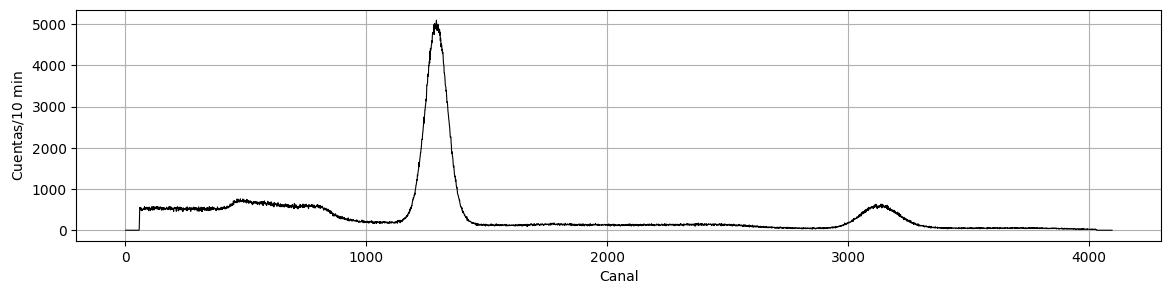


Resultados:

μ1 = 1290.8(2) canales
σ1 = 45.7(2) canales
FWHM1 = 107.6(1) canales
I1 = 549864(735) canal·cuentas

μ2 = 3131.4(2) canales
σ2 = 77.4(3) canales
FWHM2 = 182.4(8) canales
I2 = 104254(550) canal·cuentas


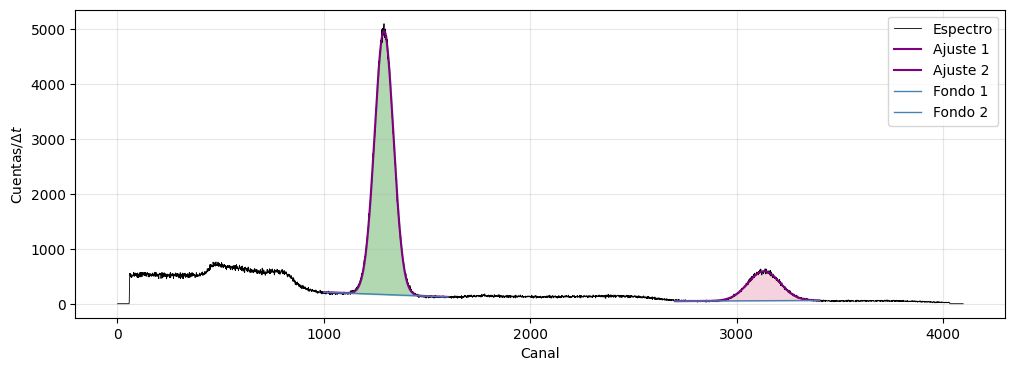

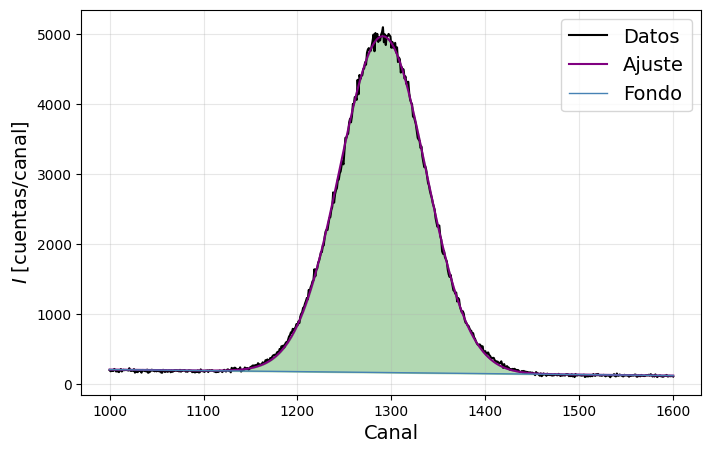

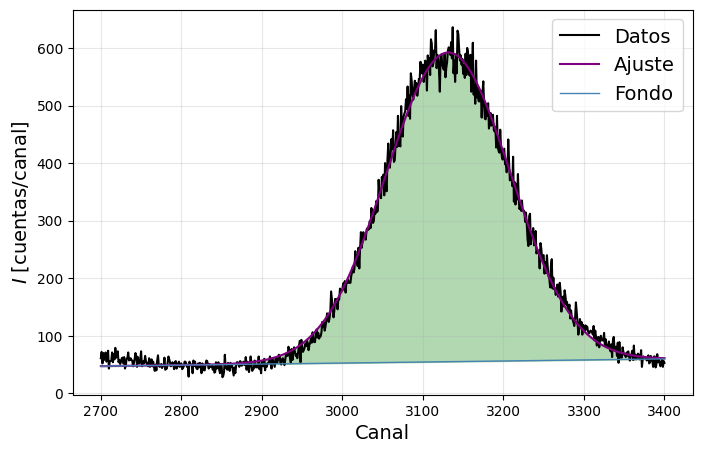

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def gauss_bg(x, mu, sigma, A, a0, a1):                                               # una gaussiana con fondo lineal mx + b
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + a0 + a1 * x

#
archivo = "Na22_10minNaI.csv"                    # archivo con los datos
data = pd.read_csv(archivo)
x = data.iloc[:, 0].values                       # canal
y = data.iloc[:, 1].values                       # cuentas

# para ver el espectro completo
plt.figure(figsize=(14,3))
plt.plot(x, y, lw=0.8, color='black')
plt.xlabel("Canal")
plt.ylabel("Cuentas/$10$ min")                                                         # acomodar el \Delta t de acuerdo al núcleo
plt.grid(True)
plt.show()


# defino la región del primer pico
x_min1, x_max1 = 1000, 1600                                                              # límites a ojo para empezar
mask1 = (x >= x_min1) & (x <= x_max1)
x_region1 = x[mask1]
y_region1 = y[mask1]

                                                                                      # estimaciones iniciales que voy a ajustar:
mu1_guess = x_region1[np.argmax(y_region1)]                                           # centro inicial en el máximo local
A1_guess = y_region1.max()                                                            # altura inicial
sigma1_guess = 30.0                                                                   # ancho inicial (10% del rango)
a0_guess = np.median(y_region1)                                                       # valor medio como base inicial
a1_guess = 0.0                                                                        # pendiente inicial nula

p0_1 = [mu1_guess, sigma1_guess, A1_guess, a0_guess, a1_guess]

# Ajuste no lineal con todos los parámetros libres
popt1, pcov1 = curve_fit(gauss_bg, x_region1, y_region1, p0=p0_1, maxfev=20000)
mu1, sigma1, A1, a0_1, a1_1 = popt1
perr1 = np.sqrt(np.diag(pcov1))


# defino la región del segundo pico (todo igual pero con estimaciones a ojo para el pico más a la derecha)
x_min2, x_max2 = 2700, 3400
mask2 = (x >= x_min2) & (x <= x_max2)
x_region2 = x[mask2]
y_region2 = y[mask2]

mu2_guess = x_region2[np.argmax(y_region2)]
A2_guess = y_region2.max()
sigma2_guess = 50.0
a0_guess = np.median(y_region2)
a1_guess = 0.0

p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess, a1_guess]

popt2, pcov2 = curve_fit(gauss_bg, x_region2, y_region2, p0=p0_2)
mu2, sigma2, A2, a0_2, a1_2 = popt2
perr2 = np.sqrt(np.diag(pcov2))


c = np.sqrt(2 * np.pi)

def intensidad(A, sigma, pcov):
    varA = pcov[2, 2]
    varsig = pcov[1, 1]
    covA_sig = pcov[2, 1]
    I = A * sigma * c
    varI = (sigma * c) ** 2 * varA + (A * c) ** 2 * varsig + 2 * (sigma * c) * (A * c) * covA_sig
    dI = np.sqrt(varI)
    return I, dI

I1, dI1 = intensidad(A1, sigma1, pcov1)
I2, dI2 = intensidad(A2, sigma2, pcov2)

FWHM1 = 2.355 * sigma1
FWHM2 = 2.355 * sigma2
dFWHM1 = 2.355 * perr1[1]
dFWHM2 = 2.355 * perr2[1]



def fmt_par(x, dx):
    if np.isnan(dx):
        return f"{x:.4g}"
    dec = int(np.floor(np.log10(abs(dx)))) if dx != 0 else 0
    ndec = max(0, -dec)
    x_str = f"{x:.{ndec}f}"
    dx_str = str(int(round(dx * 10**ndec)))
    return f"{x_str}({dx_str})"

# --- RESULTADOS ---
print("\nResultados:\n")
print(f"μ1 = {fmt_par(mu1, perr[1])} canales")
print(f"σ1 = {fmt_par(sigma1, perr[2])} canales")
print(f"FWHM1 = {fmt_par(FWHM1, dFWHM1)} canales")
print(f"I1 = {fmt_par(I1, dI1)} canal·cuentas")
print(f"\nμ2 = {fmt_par(mu2, perr[4])} canales")
print(f"σ2 = {fmt_par(sigma2, perr[5])} canales")
print(f"FWHM2 = {fmt_par(FWHM2, dFWHM2)} canales")
print(f"I2 = {fmt_par(I2, dI2)} canal·cuentas")

xf1 = np.linspace(x_region1.min(), x_region1.max(), 800)
xf2 = np.linspace(x_region2.min(), x_region2.max(), 800)
fit1 = gauss_bg(xf1, *popt1)
fit2 = gauss_bg(xf2, *popt2)
bg1 = a0_1 + a1_1 * xf1
bg2 = a0_2 + a1_2 * xf2

plt.figure(figsize=(12, 4))
plt.plot(x, y, color='black', lw=0.6, label='Espectro')
plt.plot(xf1, fit1, color='purple', lw=1.5, label="Ajuste 1")
plt.plot(xf2, fit2, color='purple', lw=1.5, label="Ajuste 2")
plt.plot(xf1, bg1, color='steelblue', lw=1, label='Fondo 1')
plt.plot(xf2, bg2,color='steelblue', lw=1, label='Fondo 2')
plt.fill_between(xf1, bg1, fit1, where=(fit1 > bg1), color='green', alpha=0.3)
plt.fill_between(xf2, bg2, fit2, where=(fit2 > bg2), color='palevioletred', alpha=0.3)
plt.xlabel("Canal")
plt.ylabel("Cuentas/$\Delta t$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# PICO 1
plt.figure(figsize=(8, 5))
plt.plot(x_region1, y_region1, color='black', label='Datos')
plt.plot(xf1, fit1, 'purple', lw=1.5, label='Ajuste')
plt.plot(xf1, bg1, 'steelblue', lw=1, label='Fondo')
plt.fill_between(xf1, bg1, fit1, where=(fit1 > bg1), color='green', alpha=0.3)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
#plt.title("Primer pico (Na-22)")
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# PICO 2
plt.figure(figsize=(8, 5))
plt.plot(x_region2, y_region2, color='black', label='Datos')
plt.plot(xf2, fit2, 'purple', lw=1.5, label='Ajuste')
plt.plot(xf2, bg2, 'steelblue', lw=1, label='Fondo')
plt.fill_between(xf2, bg2, fit2, where=(fit2 > bg2), color='green', alpha=0.3)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
#plt.title("Segundo pico (Na-22)")
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


#Calibración en energía

=== Ajuste de canal vs energía ===
b0 = 32.495 ± 0.827
b1 = 2.42890 ± 0.00087
-0.0006231181864020533

=== Resultados de la calibración en energía ===
a0 = -13.38(034) keV
a1 = 0.41171(000) keV/canal

Ecuación de calibración:
E = -13.38(034) + 0.41171(000) * canal


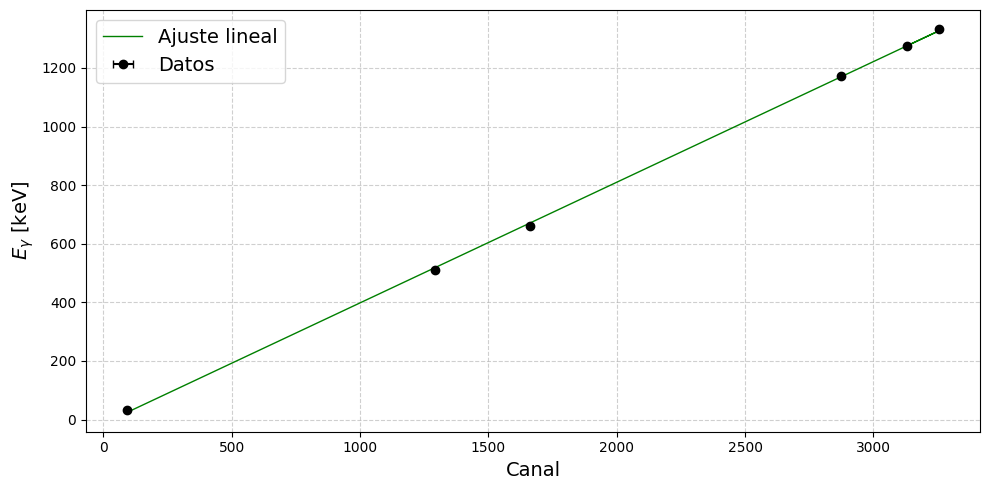


=== Comparación Energía Teórica vs Ajustada ===
   Canal    E_teórico (keV)     E_ajustado (keV)     ΔE (keV)    Error %
   90.89             32.800               24.042        8.758     26.702
 1290.80            511.000              518.056       -7.056      1.381
 1661.67            661.657              670.746       -9.089      1.374
 2873.20           1173.228             1169.544        3.684      0.314
 3256.80           1332.490             1327.476        5.014      0.376
 3131.40           1274.537             1275.848       -1.311      0.103


In [4]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

E = np.array([32.8, 511, 661.657, 1173.228, 1332.490, 1274.537])               # datos de energía tomados de la tabla
mu = np.array([90.89, 1290.8, 1661.67, 2873.2, 3256.8, 3131.4])                  # datos de mu hallados en los ajustes del punto 1
dmu = np.array([0.6, 0.2, 0.07, 0.2, 0.2, 0.2])                                 # incertidumbres asociadas a cada canal
dE = np.ones_like(E)                                                            # incertidumbre fija para la energía


def f(E, b0, b1):
    return b0 + b1 * E                                                          # canal = b0 + b1 * energía

popt, pcov = curve_fit(f, E, mu, sigma=dE, absolute_sigma=True)
b0, b1 = popt
db0, db1 = np.sqrt(np.diag(pcov))

print("=== Ajuste de canal vs energía ===")
print(f"b0 = {b0:.3f} ± {db0:.3f}")
print(f"b1 = {b1:.5f} ± {db1:.5f}")
print(pcov[0,1])

# invierto
# E = a0 + a1 * canal
a1 = 1 / b1
a0 = -b0 / b1
da1 = db1 / b1**2
da0 = np.sqrt((db0/b1)**2 + (b0*db1/b1**2)**2)


def format_uncertainty(value, uncertainty):
    n_decimals = int(-np.floor(np.log10(uncertainty))) + 1
    value_rounded = round(value, n_decimals)
    uncertainty_rounded = round(uncertainty, n_decimals)
    digits = str(uncertainty_rounded).replace('.', '')[:3]
    return f"{value_rounded:.{n_decimals}f}({digits})"

a0_str = format_uncertainty(a0, da0)
a1_str = format_uncertainty(a1, da1)

print("\n=== Resultados de la calibración en energía ===")
print(f"a0 = {a0_str} keV")
print(f"a1 = {a1_str} keV/canal")
print(f"\nEcuación de calibración:")
print(f"E = {a0_str} + {a1_str} * canal")


plt.figure(figsize=(10,5))
plt.errorbar(mu, E, xerr=dmu, fmt='o', color='black', capsize=3, label='Datos')
plt.plot(mu, a0 + a1*mu, color='green', lw=1, label='Ajuste lineal')
plt.xlabel('Canal', fontsize=14)
plt.ylabel('$E_{\\gamma}$ [keV]', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, ls='--', alpha=0.6)
plt.tight_layout()
plt.show()


E_ajustado = a0 + a1 * mu
dif = E - E_ajustado
error_rel = np.abs(dif / E) * 100

print("\n=== Comparación Energía Teórica vs Ajustada ===")
print(f"{'Canal':>8} {'E_teórico (keV)':>18} {'E_ajustado (keV)':>20} {'ΔE (keV)':>12} {'Error %':>10}")
for i in range(len(E)):
    print(f"{mu[i]:8.2f} {E[i]:18.3f} {E_ajustado[i]:20.3f} {dif[i]:12.3f} {error_rel[i]:10.3f}")


# Borde Compton y pico de retrodispersión

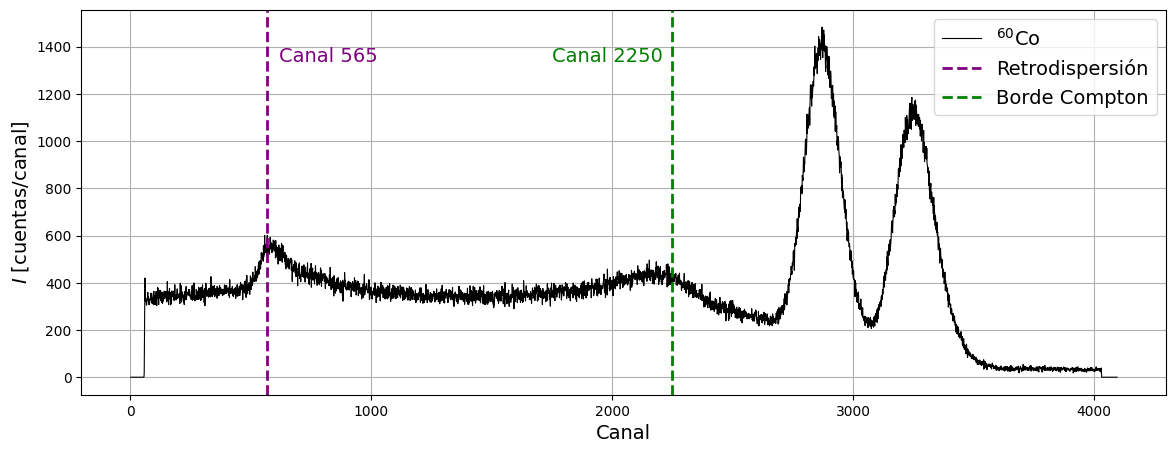

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


archivo = "Co60_10minNaI.csv"                                                         # cambio entre .csv
data = pd.read_csv(archivo)                                                           # columna 0: canal, columna 1: cuentas

x = data.iloc[:,0].values
y = data.iloc[:,1].values

retrodispersión = 565
borde = 2250

# Teóricos (keV)
E_C1 = 963.1
E_R1 = 209.8
E_C2 = 1118.1
E_R2 = 214.3

# Experimentales (keV)
E_C1x = 911.3
E_R1x = 218.8
E_R2x = 220.8

# para ver el espectro completo
plt.figure(figsize=(14,5))
plt.plot(x, y, lw=0.8, color='black', label='$^{60}$Co')
plt.axvline(x=retrodispersión, color='purple', lw=2, linestyle='--', label='Retrodispersión')
plt.axvline(x=borde, color='green', lw=2,linestyle='--', label='Borde Compton')
plt.text(retrodispersión + 50, max(y)*0.9, f'Canal {retrodispersión}', color='purple', fontsize=14)
plt.text(borde - 500, max(y)*0.9, f'Canal {borde}', color='green', fontsize=14)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()


# para ver el espectro completo
plt.figure(figsize=(14,5))
plt.plot(x, y, lw=0.8, color='black', label='$^{60}$Co')
plt.axvline(x=retrodispersión, color='purple', lw=2, linestyle='--', label='Retrodispersión')
plt.axvline(x=borde, color='green', lw=2,linestyle='--', label='Borde Compton')
plt.text(retrodispersión + 50, max(y)*0.9, f'Canal {retrodispersión}', color='purple', fontsize=14)
plt.text(borde - 500, max(y)*0.9, f'Canal {borde}', color='green', fontsize=14)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.show()

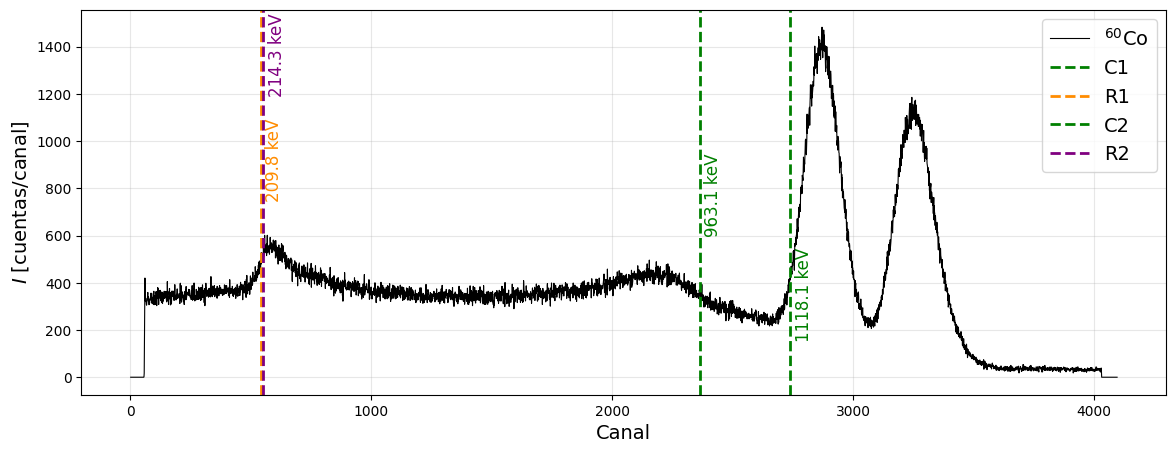

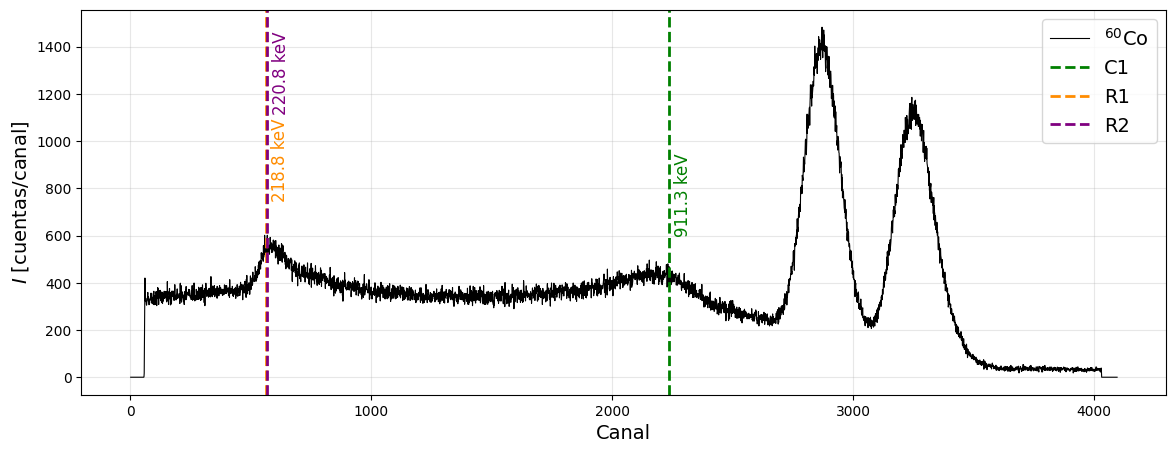

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


archivo = "Co60_10minNaI.csv"
data = pd.read_csv(archivo)

x = data.iloc[:,0].values
y = data.iloc[:,1].values

# ajuste del punto anterior, para canales
def energia_a_canal(E):
    return 32.4 + 2.42 * E

# valores teóricos [keV]
E_teoricos = [963.1, 209.8, 1118.1, 214.3]
colores_teoricos = ['green','darkorange','green','purple']
labels_teoricos = ['C1','R1','C2','R2']
C_teoricos = [energia_a_canal(E) for E in E_teoricos]

# posición de los textos
y_text_teorico = [max(y)*0.4, max(y)*0.5, max(y)*0.1, max(y)*0.8]

plt.figure(figsize=(14,5))
plt.plot(x, y, lw=0.8, color='black', label='$^{60}$Co')

for canal, E, color, label, y_pos in zip(C_teoricos, E_teoricos, colores_teoricos, labels_teoricos, y_text_teorico):
    plt.axvline(x=canal, color=color, lw=2, linestyle='--', label=f'{label}')
    plt.text(canal + 20, y_pos, f'{E:.1f} keV', color=color, fontsize=12, rotation=90, va='bottom')

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
#plt.title("Líneas teóricas convertidas a canal (texto ajustado)", fontsize=1)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# valores experimentales [keV]
E_exp = [911.3, 218.8, 220.8]
colores_exp = ['green','darkorange','purple']
labels_exp = ['C1','R1','R2']
C_exp = [energia_a_canal(E) for E in E_exp]

# posiciones y ajustadas para que no se solapen
y_text_exp = [max(y)*0.4, max(y)*0.5, max(y)*0.75]


plt.figure(figsize=(14,5))
plt.plot(x, y, lw=0.8, color='black', label='$^{60}$Co')

for canal, E, color, label, y_pos in zip(C_exp, E_exp, colores_exp, labels_exp, y_text_exp):
    plt.axvline(x=canal, color=color, lw=2, linestyle='--', label=f'{label}')
    plt.text(canal + 20, y_pos, f'{E:.1f} keV', color=color, fontsize=12, rotation=90, va='bottom')

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
#plt.title("Líneas experimentales convertidas a canal (texto ajustado)", fontsize=16)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


#Razón compton-fotopico

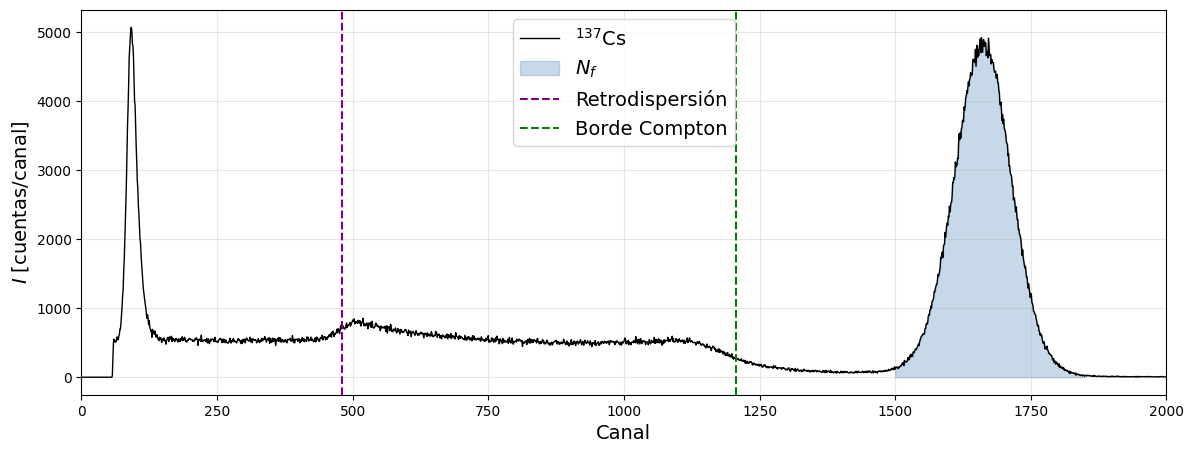


FOTOPICO - ALTURA MÁXIMA
Canal máximo: 1659
Altura máxima: 4923(70) cuentas/canal


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# config basica
plt.rcParams['figure.figsize'] = (14, 5)


# cargar datos cs137
# uploaded = files.upload()
filename = 'Cs137_5minNaI.csv'
df = pd.read_csv(filename)
x = df.iloc[:,0].values
y = df.iloc[:,1].values

#datos fotopico
N_f_teo = 621062              # determinado antes
fotopico_canal = 1661.67

#datos region fotopico
fotopico_li = 1500
fotopico_ls = 1850

mask_fotopico = (x >= fotopico_li) & (x <= fotopico_ls)

# sumar cuentas en region fotopico (SIN CORRECCION DE FONDO)
N_f = np.sum(y[mask_fotopico]) #valor exp

#incertidumbre, como la ecuacion es A * \sigma * √(2π)
# donde A y \sigma tienen incertidumbres

# encontrar el máximo dentro del rango
y_max = np.max(y[mask_fotopico])
x_max = x[mask_fotopico][np.argmax(y[mask_fotopico])]

# incertidumbre de Poisson para la altura máxima
sigma_y_max = np.sqrt(y_max) #incertidumbre de A

#determinacion de sigma

#datos region compton
comp_li = 480.04
comp_ls = 1205.73

mask_compton = (x >= comp_li) & (x <= comp_ls)

# sumar cuentas en region compton (SIN CORRECCION DE FONDO)
N_C = np.sum(y[mask_compton])


retrodispersión = 480.04
compton = 1205.73

# GRAFICO
plt.plot(x, y, color = 'black', linewidth=1, label='$^{137}$Cs')
#plt.axvspan(comp_li, comp_ls, alpha=0.3, color='red', label='Región Compton')
plt.fill_between(x, 0, y, where=mask_fotopico, color='steelblue', alpha=0.3, label='$N_f$')
plt.axvline(retrodispersión, color='purple', linestyle='--', lw=1.5, label='Retrodispersión')
plt.axvline(compton, color='green', linestyle='--', lw=1.5, label='Borde Compton')
plt.xlim(0, 2000)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I$ [cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()


print("\n" + "="*40)
print("FOTOPICO - ALTURA MÁXIMA")
print("="*40)
print(f"Canal máximo: {x_max}")
print(f"Altura máxima: {int(y_max)}({int(sigma_y_max)}) cuentas/canal")



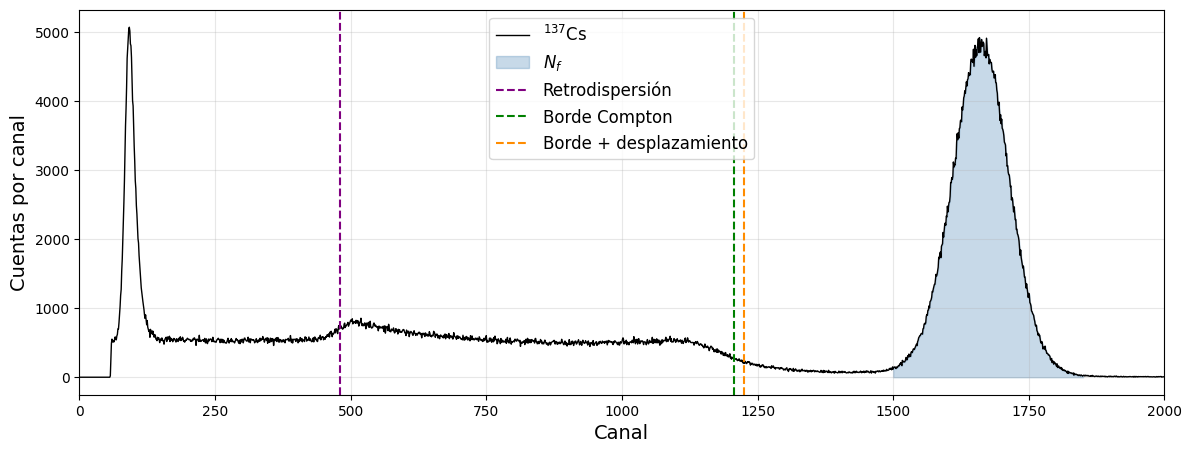


TABLA RESUMEN
Región Compton: canales 480.04 - 1205.73
N_C = 402241 ± 4720 (total)

σ(E_C) = 45.8 keV  →  σ_canal(E_C) = 18.8 canales

N_f = 641726 ± 801
r = 0.6268 ± 0.0074


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


plt.rcParams['figure.figsize'] = (14, 5)
filename = 'Cs137_5minNaI.csv'
df = pd.read_csv(filename)
x = df.iloc[:, 0].values   # canales
y = df.iloc[:, 1].values   # cuentas

# cosas del ajuste que ya había hecho
a0 = -13.38       # intercepto
a1 = 0.41         # pendiente
sigma_a0 = 0.03   # incertidumbre de a0
sigma_a1 = 0.00   # despreciable


# Región Compton
comp_li = 480.04  # retrodispersión
comp_ls = 1205.73 # borde Compton

mask_compton = (x >= comp_li) & (x <= comp_ls)
N_C = np.sum(y[mask_compton])     # cuentas en la región

E_gamma = 669.7    # energía del fotopico [keV]
sigma_a0_E = sigma_a0 * 1661.7 / a1   # incerteza pequeña asociada a calibración
sigma_Eg = 49.8  # incertidumbre de E_gamma

# σ(E_C) y σ(E_R) a partir de propagación (hecho manualmente en el Overleaf)
sigma_EC = 45.8  # keV
sigma_ER = 49.8  # keV

# convierto de keVs a canales
sigma_canal_EC = np.sqrt(sigma_a0**2 + (a1 * sigma_EC)**2)
sigma_canal_ER = np.sqrt(sigma_a0**2 + (a1 * sigma_ER)**2)


def integrar_cuentas(x, y, li, ls):
    mask = (x >= li) & (x <= ls)
    return np.sum(y[mask])

N_nom = integrar_cuentas(x, y, comp_li, comp_ls)

# N_C con desplazamiento del límite superior
N_desplazado = integrar_cuentas(x, y, comp_li, comp_ls + sigma_canal_EC)

# Incertidumbre por variación de límite (definición analítica)
sigma_NC_límites = abs(N_desplazado - N_nom)

# Incertidumbre total
sigma_NC_total = np.sqrt(sigma_NC_límites**2)


fotopico_li = 1500
fotopico_ls = 1850
mask_fotopico = (x >= fotopico_li) & (x <= fotopico_ls)
N_f = np.sum(y[mask_fotopico])
sigma_N_f = np.sqrt(N_f)

# razón
r = N_C / N_f
sigma_r = r * np.sqrt((sigma_NC_total/N_C)**2 + (sigma_N_f/N_f)**2)


plt.plot(x, y, color='black', linewidth=1, label='$^{137}$Cs')
plt.fill_between(x, 0, y, where=mask_fotopico, color='steelblue', alpha=0.3, label='$N_f$')
#plt.axvspan(comp_li, comp_ls, alpha=0.2, color='red', label='Región Compton')
plt.axvline(comp_li, color='purple', linestyle='--', lw=1.5, label='Retrodispersión')
plt.axvline(comp_ls, color='green', linestyle='--', lw=1.5, label='Borde Compton')
plt.axvline(comp_ls + sigma_canal_EC, color='darkorange', linestyle='--', lw=1.5, label='Borde + desplazamiento')
plt.xlim(0, 2000)
plt.xlabel("Canal", fontsize=14)
plt.ylabel("Cuentas por canal", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()


print("\n" + "="*40)
print("TABLA RESUMEN")
print("="*40)
print(f"Región Compton: canales {comp_li:.2f} - {comp_ls:.2f}")
print(f"N_C = {N_C:.0f} ± {sigma_NC_total:.0f} (total)")
print(f"\nσ(E_C) = {sigma_EC:.1f} keV  →  σ_canal(E_C) = {sigma_canal_EC:.1f} canales")
print(f"\nN_f = {N_f:.0f} ± {sigma_N_f:.0f}")
print(f"r = {r:.4f} ± {sigma_r:.4f}")


In [8]:
# Derivada de E_C respecto a E_\gamma

E_gamma = 669.74
m_e = 511.0
dEC_dEg = (4*E_gamma*(m_e+2*E_gamma)-4*E_gamma**2) / (m_e + 2*E_gamma)**2

dEC_dme = -(2*E_gamma**2) / (m_e + 2*E_gamma)**2

print(dEC_dEg)
print(dEC_dme)

0.923744177621588
-0.2619833432933086
